# Implementing Deep Q-Learning with Experience Replay

Based on Playing Atari with Deep Reinforcement Learning [link](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)

Main aim is to train a *policy* that tries to maximise $R_{t_0} = \sum_{t=t_0}^{\inf}\gamma^{t-t_0}r_t$ (the discounted cumulative reward) with the discount $0 < \gamma < 1$

**Q-learning** in particular assumes the existence of a function $Q^\star: \text{State}\times\text{Action}\rightarrow \mathbb{R}$ that approximates the return given a state and an action.

Hence, one can construct a policy that maximises the expected reward: $\pi^\star(s)=\text{argmax}_aQ^\star(s, a)$

We initialise this **Q-table** and then update it at each training step as so: $Q^\pi(s,a)=r + \gamma Q^\pi(s', \pi(s'))$

Define the temporal difference error $\delta$ as $\delta = Q(s, a) - (r + \gamma \text{max}_aQ(s',a))$

Minimise error using *Huber loss*, so $\mathcal{L} = \frac{1}{|B|}_{(s, a, s', r)\in B}\sum \mathcal{L}(\delta)$ where $\mathcal{L}(\delta) = \frac{1}{2}\delta^2$ if $\delta|\leq 1$ or $|\delta| - \frac{1}{2}$ otherwise.

---
### Includes

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gym
from preprocessing import AtariPreprocessing
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cpu")

---
### Helper functions

In [2]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

In [4]:
def get_screen():   
    # transpose it into torch order (CHW)
    screen = env._get_obs().transpose((2, 0, 1))
    screen = torch.from_numpy(screen)
    
    # add a batch dimension (BCHW)
    return screen.unsqueeze(0).to(device)

"""
env.reset()
env.step(3)
plt.figure()
plt.imshow(np.average(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), axis=2), interpolation='none')
plt.title('Example extracted screen')
plt.show()

env.step(3)
plt.figure()
plt.imshow(np.average(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), axis=2), interpolation='none')
plt.title('Example extracted screen')
plt.show()

env.step(3)
plt.figure()
plt.imshow(np.average(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), axis=2), interpolation='none')
plt.title('Example extracted screen')
plt.show()
"""

"\nenv.reset()\nenv.step(3)\nplt.figure()\nplt.imshow(np.average(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), axis=2), interpolation='none')\nplt.title('Example extracted screen')\nplt.show()\n\nenv.step(3)\nplt.figure()\nplt.imshow(np.average(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), axis=2), interpolation='none')\nplt.title('Example extracted screen')\nplt.show()\n\nenv.step(3)\nplt.figure()\nplt.imshow(np.average(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), axis=2), interpolation='none')\nplt.title('Example extracted screen')\nplt.show()\n"

---
### Code

In [5]:
# (state, action) -> (next_state, reward)
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward'))

# replay memory D with capacity N
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
BATCH_SIZE = 32
GAMMA = 0.95
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 10000 # in number of steps

FRAME_SKIP = 4

# resize to 84, make greyscale and scale observations from 0 to 1
env = AtariPreprocessing(gym.make('BreakoutNoFrameskip-v0'), frame_skip=FRAME_SKIP, screen_size=84, grayscale_newaxis=True, scale_obs=True)

class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(FRAME_SKIP, 16, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(w, kernel_size = 8, stride = 4), kernel_size = 4, stride = 2)
        convh = conv2d_size_out(conv2d_size_out(h, kernel_size = 8, stride = 4), kernel_size = 4, stride = 2)
        linear_input_size = convw * convh * 32
        
        self.fc = nn.Linear(linear_input_size, 256)
        self.head = nn.Linear(256, outputs)
        
        self.steps_done = 0

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.fc(x.view(x.size(0), -1)))
        return self.head(x)
    
    def act(self, state):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * (1. - min(1., self.steps_done / EPS_DECAY))
        self.steps_done += FRAME_SKIP

        # With probability eps select a random action
        if random.random() < eps_threshold:
            return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

        # otherwise select action = maxa Q∗(φ(st), a; θ)
        with torch.no_grad():
            return np.argmax(self(state)).view(1,1)
    
    def experience_replay(self):
        if len(memory) < BATCH_SIZE:
            return
        
        transitions = memory.sample(BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        next_state_values[non_final_mask] = self(non_final_next_states).max(1)[0].detach()
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

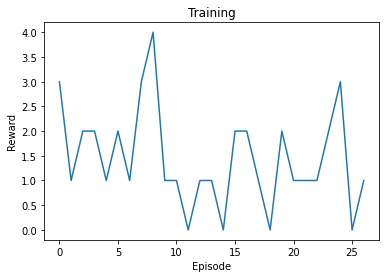

In [ ]:
# Get number of actions and observations from gym action space
n_actions = env.action_space.n

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
print(init_screen.shape)
# Initialize action-value function Q with random weights
dqnAgent = DQN(screen_height, screen_width, n_actions).to(device)

# Optimizer
learning_rate = 1e-3
optimizer = optim.Adam(dqnAgent.parameters(), lr=learning_rate)

# Initialize replay memory D to capacity N (= 100000)
memory = ReplayMemory(1000000)

num_episodes = 300 # M
episode_durations = []
for i_episode in range(num_episodes):
    env.reset()
    state = get_screen()
    
    overall_reward = 0
    for t in count():
        #env.render()
        
        # Execute action a_t in emulator and observe reward r_t and image x_{t+1}
        action = dqnAgent.act(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        overall_reward += reward

        # preprocess φ_{t+1} = φ(s_{t+1})
        if not done:
            next_state = get_screen()
        else:
            next_state = None

        # Store transition (φt, at, rt, φt+1) in D
        memory.store(state, action, next_state, reward)

        state = next_state

        dqnAgent.experience_replay()
        
        if done:
            episode_durations.append(overall_reward)
            plot_durations()
            break

print('Complete')
plot_durations()